>### 사전 훈련된 모델 활용하기
- 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법: 사전 훈련된 모델 사용
- 사전 훈련된 모델(pretrained model)이란?
    - 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련된 모델
- 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import image_dataset_from_directory
import zipfile

import os, shutil, pathlib, datetime

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


class ResidualCNN:
    def __init__(self):
        self.original_dir = pathlib.Path("extracted_files/train")
        self.new_base_dir = pathlib.Path("cats_vs_dogs_small")
        self.path_name = "cats_vs_dogs_small"

        self.train_ds = None
        self.val_ds = None
        self.test_ds = None
        self.class_names = None

        self.model = None
        self.history = None

        self.AUTOTUNE = tf.data.AUTOTUNE

    def download_and_extract(self):
        file_name = 'dogs-vs-cats.zip'
        if os.path.exists(file_name):
            pass
        else:
            import gdown
            gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output=file_name)

            with zipfile.ZipFile(file_name, 'r') as zip_ref:
                zip_ref.extractall('extracted_files/')
                with zipfile.ZipFile('extracted_files/train.zip', 'r') as zip_2nd:
                    zip_2nd.extractall('extracted_files/')


    def make_subset(self, subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = self.new_base_dir / subset_name / category
            os.makedirs(dir)
            fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
            for fname in fnames:
                shutil.copyfile(src=self.original_dir / fname, dst=dir / fname)


    def prepare_data(self):
        if os.path.exists(self.path_name):
            pass
        else:
            self.make_subset("train", start_index=0, end_index=1000)
            self.make_subset("validation", start_index=1000, end_index=1500)
            self.make_subset("test", start_index=1500, end_index=2500)

        self.train_ds = image_dataset_from_directory(
            self.new_base_dir / "train",
            image_size=(180, 180),
            batch_size=32)
        self.val_ds = image_dataset_from_directory(
            self.new_base_dir / "validation",
            image_size=(180, 180),
            batch_size=32)
        self.test_ds = image_dataset_from_directory(
            self.new_base_dir / "test",
            image_size=(180, 180),
            batch_size=32)

        self.class_names = self.train_ds.class_names


    def visualize_data(self, check):
        if check:
            plt.figure(figsize=(10, 10))
            for images, labels in self.train_ds.take(1):
                for i in range(9):
                    ax = plt.subplot(3, 3, i + 1)
                    plt.imshow(images[i].numpy().astype("uint8"))
                    plt.title(self.class_names[labels[i]])
                    plt.axis("off")
                plt.show()
        else:
            pass


    def data_augmentation(self, inputs, check):
        data_augmenter = keras.Sequential(
            [
                layers.RandomFlip('horizontal'),
                layers.RandomRotation(0.1),
                layers.RandomZoom(0.2)
            ]
        )

        if check:
            plt.figure(figsize=(10, 10))
            for images, _ in self.train_ds.take(1):
                for i in range(9):
                    augmented_images = data_augmenter(images)
                    ax = plt.subplot(3, 3, i + 1)
                    plt.imshow(augmented_images[0].numpy().astype('uint8'))
                    plt.axis('off')
                plt.show()

        augmented_images = data_augmenter(inputs)

        return augmented_images


    def build_model(self, check=False):
        aug_check = check

        inputs = keras.Input(shape=(180, 180, 3))

        x = self.data_augmentation(inputs, check=aug_check)

        x = layers.Rescaling(1. / 255)(x)

        x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)

        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x)

        outputs = layers.Dense(1, activation='sigmoid')(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs)


    def train_model(self, epochs=10):
        current_date = datetime.datetime.now()
        self.today_date = current_date.date()

        self.model.compile(optimizer='rmsprop',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

        callbacks = [keras.callbacks.ModelCheckpoint(
            filepath=f'{self.today_date}_computer_vision.keras',
            save_best_only=True,
            monitor='val_loss')
        ]

        self.history = self.model.fit(self.train_ds,
                                      epochs=epochs,
                                      callbacks=callbacks,
                                      batch_size=32,
                                      validation_data=self.val_ds)


    def plot_model_summary(self):
        self.model.summary()


    def plot_training_history(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(len(acc))

        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
        plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, 'bo', label='Training Loss')
        plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()


    def test_evaluation(self):
        test_model = keras.models.load_model(f'{self.today_date}_computer_vision.keras')
        test_loss, test_acc = test_model.evaluate(self.test_ds)
        print(f"테스트 정확도: {test_acc:.3f}")


In [3]:
# Create an instance of the ResidualCNN class
residual_cnn = ResidualCNN()

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


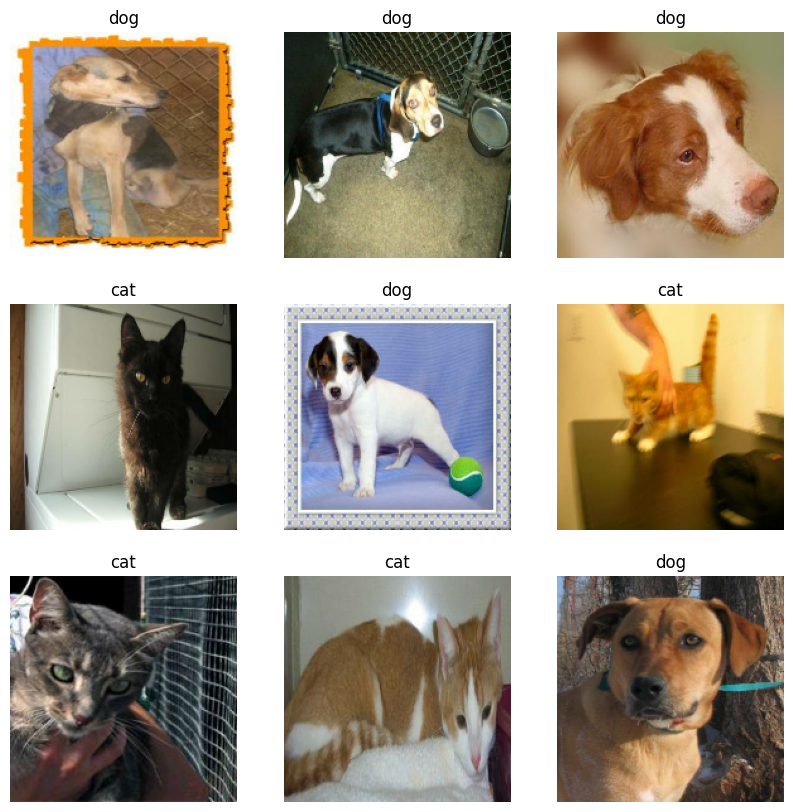

In [4]:
# Execute the steps
residual_cnn.download_and_extract()
residual_cnn.prepare_data()
residual_cnn.visualize_data(check=True)

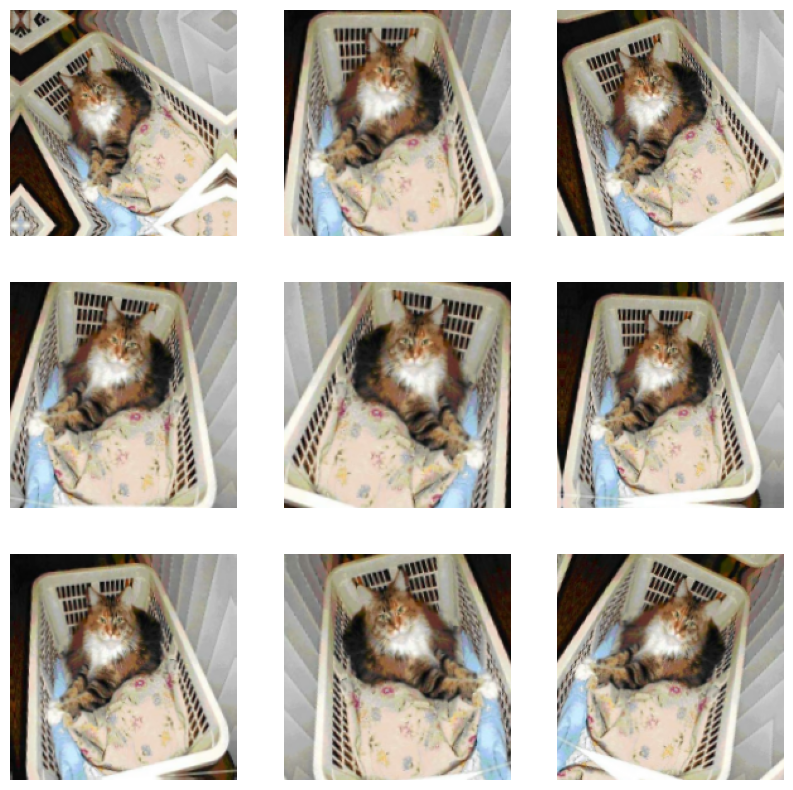

In [5]:
# Execute the step as build model
# need to check why this picture is something wrong.
residual_cnn.build_model(check=True)

In [6]:
# Execute the step as train model
residual_cnn.train_model(epochs=100)

Epoch 1/100
63/63 [==============================] - 10s 79ms/step - loss: 0.7252 - accuracy: 0.5025 - val_loss: 0.6921 - val_accuracy: 0.5990
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 0.6996 - accuracy: 0.5385 - val_loss: 0.8742 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6810 - accuracy: 0.6010 - val_loss: 0.6566 - val_accuracy: 0.6140
Epoch 4/100
63/63 [==============================] - 5s 73ms/step - loss: 0.6709 - accuracy: 0.6145 - val_loss: 0.6563 - val_accuracy: 0.5850
Epoch 5/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6534 - accuracy: 0.6265 - val_loss: 0.6536 - val_accuracy: 0.5940
Epoch 6/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6436 - accuracy: 0.6405 - val_loss: 0.6396 - val_accuracy: 0.6050
Epoch 7/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6191 - accuracy: 0.6685 - val_loss: 0.6320 - val_accuracy: 0.6370
Epoch

In [7]:
# Execute the step as plot model summary
residual_cnn.plot_model_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

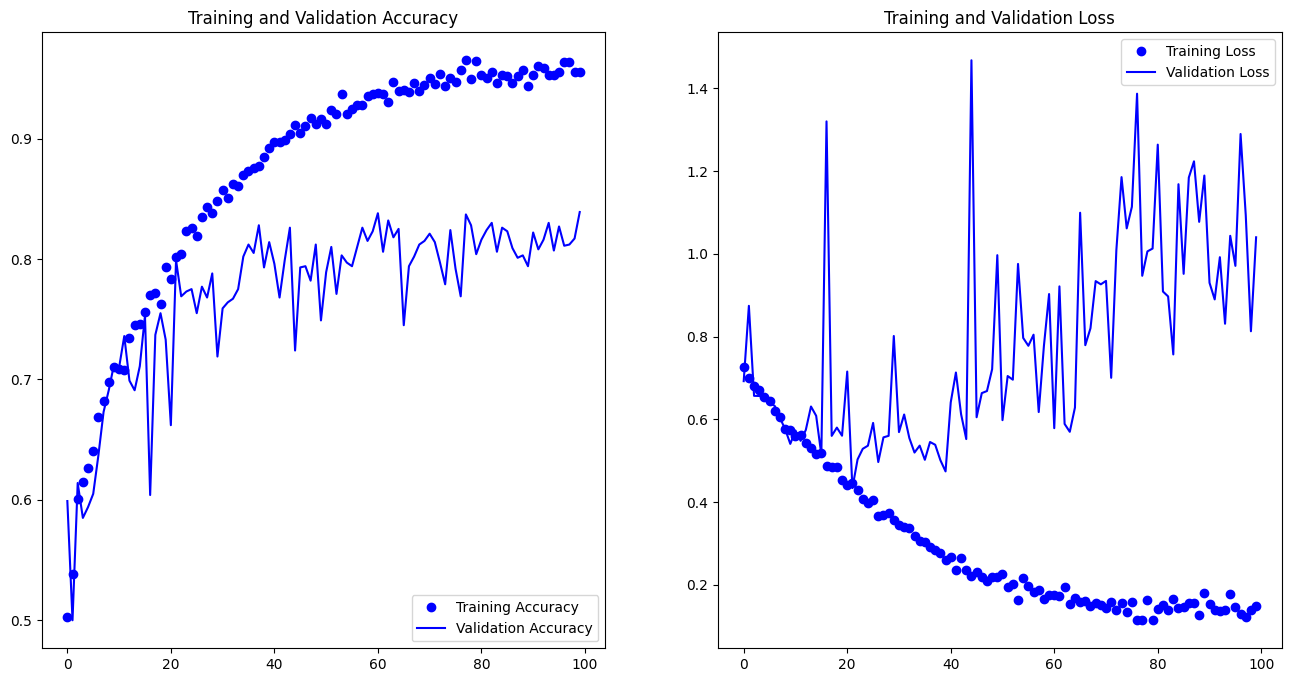

In [8]:
# Execute the step as plot accuracy / loss
residual_cnn.plot_training_history()

In [9]:
# Execute the step as test evaluation
residual_cnn.test_evaluation()

63/63 [==============================] - 1s 9ms/step - loss: 0.4786 - accuracy: 0.7740
테스트 정확도: 0.774
